<a href="https://colab.research.google.com/github/ArthAgrawal/Audio-Forensics-Research/blob/main/Audio_Forensics_ASVSpoof2019_Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib.pyplot as plt

directories = {
    'Bonafide': '/content/drive/MyDrive/LA_Dataset_Final/Bonafide',
    'Spoof-A01': '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A01',
    'Spoof-A02': '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A02',
    'Spoof-A03': '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A03',
    'Spoof-A04': '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A04',
    'Spoof-A05': '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A05',
    'Spoof-A06': '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A06',
}

In [3]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [4]:
import os
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display

# Converting audio to Mel spectrogram
def audio_to_mel_spectrogram(file_path, sr=11000, n_mels=256, max_time_frames=256):
    try:
        y, original_sr = librosa.load(file_path, sr=sr)  # Load audio with target sampling rate
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)  # Compute Mel spectrogram
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to dB scale

        # Truncate or pad to max_time_frames
        if mel_spectrogram.shape[1] > max_time_frames:
            mel_spectrogram = mel_spectrogram[:, :max_time_frames]
        else:
            pad_width = max_time_frames - mel_spectrogram.shape[1]
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')

        return mel_spectrogram
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None


def load_data_from_folders(folders, labels, sr=11000, n_mels=256, max_time_frames=256):
    X, y = [], []
    for folder, label in zip(folders, labels):
        print(f"Processing {folder}...")
        for file in tqdm(os.listdir(folder)):
            file_path = os.path.join(folder, file)
            mel_spectrogram = audio_to_mel_spectrogram(file_path, sr, n_mels, max_time_frames)
            if mel_spectrogram is not None:
                X.append(mel_spectrogram)
                y.append(label)
    return np.array(X), np.array(y)


# Define dataset structure
bonafide_folder = '/content/drive/MyDrive/LA_Dataset_Final/Bonafide'
spoof_base_folder = '/content/drive/MyDrive/LA_Dataset_Final/Spoof'
spoof_classes = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06']

folders = [bonafide_folder] + [os.path.join(spoof_base_folder, spoof_class) for spoof_class in spoof_classes]
labels = [0] + [i + 1 for i in range(len(spoof_classes))]  # Bonafide=0, Spoof A01=1, A02=2, ...

X, y = load_data_from_folders(folders, labels)

print(f"Loaded {len(X)} samples.")
print(f"Shape of feature data: {X.shape}, Shape of labels: {y.shape}")

Processing /content/drive/MyDrive/LA_Dataset_Final/Bonafide...


100%|██████████| 2580/2580 [02:06<00:00, 20.40it/s]


Processing /content/drive/MyDrive/LA_Dataset_Final/Spoof/A01...


100%|██████████| 3800/3800 [02:15<00:00, 28.00it/s]


Processing /content/drive/MyDrive/LA_Dataset_Final/Spoof/A02...


100%|██████████| 3800/3800 [02:30<00:00, 25.18it/s]


Processing /content/drive/MyDrive/LA_Dataset_Final/Spoof/A03...


100%|██████████| 3800/3800 [02:21<00:00, 26.87it/s]


Processing /content/drive/MyDrive/LA_Dataset_Final/Spoof/A04...


100%|██████████| 3800/3800 [02:28<00:00, 25.54it/s]


Processing /content/drive/MyDrive/LA_Dataset_Final/Spoof/A05...


100%|██████████| 3800/3800 [02:22<00:00, 26.75it/s]


Processing /content/drive/MyDrive/LA_Dataset_Final/Spoof/A06...


100%|██████████| 3800/3800 [02:28<00:00, 25.62it/s]


Loaded 25380 samples.
Shape of feature data: (25380, 256, 256), Shape of labels: (25380,)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize each spectrogram independently to preserve spatial relationships
scaler = MinMaxScaler()
X_normalized = np.array([scaler.fit_transform(img) for img in X])

X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Reshaping for CNN input (Adding a channel dimension)
X_train = X_train[..., np.newaxis]  # Channel = 1 as Mel Spectrograms are greyscale
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Final input shape (for CNN): {X_train.shape}, {X_val.shape}, {X_test.shape}")


Training set shape: (17766, 256, 256), (17766,)
Validation set shape: (3807, 256, 256), (3807,)
Test set shape: (3807, 256, 256), (3807,)
Final input shape (for CNN): (17766, 256, 256, 1), (3807, 256, 256, 1), (3807, 256, 256, 1)


In [7]:
from tensorflow.keras import layers, models

# Convolutional feature extractor
def conv_feature_extractor(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    gap = layers.GlobalAveragePooling2D()(x)
    gmp = layers.GlobalMaxPooling2D()(x)
    features = layers.Concatenate()([gap, gmp])

    return models.Model(inputs, features, name="ConvFeatureExtractor")

def transformer_block(input_tensor, num_heads=4, key_dim=64, ff_dim=64, dropout_rate=0.1):
    # Multi-head attention
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(input_tensor, input_tensor)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Add()([x, input_tensor])  # Residual connection
    x = layers.LayerNormalization()(x)

    # Feed-forward network
    ff = layers.Dense(ff_dim, activation='relu')(x)
    ff = layers.Dropout(dropout_rate)(ff)
    x = layers.Add()([x, ff])  # Residual connection
    x = layers.LayerNormalization()(x)

    return x

def hybrid_cnn_transformer(input_shape, num_classes):
    # Convolutional feature extractor
    conv_extractor = conv_feature_extractor(input_shape)
    inputs = layers.Input(shape=input_shape)
    features = conv_extractor(inputs)

    projected_features = layers.Dense(256)(features)
    transformer_input = layers.Reshape((4, 64))(projected_features)

    # Transformer block
    transformer_output = transformer_block(transformer_input, ff_dim=64)

    x = layers.GlobalAveragePooling1D()(transformer_output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer with softmax activation
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name="HybridCNNTransformer")

model = hybrid_cnn_transformer((256, 256, 1), 7)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "HybridCNNTransformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ConvFeatureExtractor      │ (None, 512)            │        389,760 │ input_layer_3[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ ConvFeatureExtractor[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 4, 64)          │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 4, 64)          │         66,368 │ reshape_1[0][0],       │
│ (MultiHeadAttention)      │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 4, 64)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 4, 64)          │              0 │ dropout_4[0][0],       │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 4, 64)          │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4, 64)          │          4,160 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 4, 64)          │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 4, 64)          │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 4, 64)          │            128 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ layer_normalization_2… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │          8,320 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)      

 Total params: 608,903 (2.32 MB)

 Trainable params: 607,943 (2.32 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
556/556 - 54s - 97ms/step - accuracy: 0.6948 - loss: 0.7063 - val_accuracy: 0.2059 - val_loss: 5.7228 - learning_rate: 0.0010
Epoch 2/50
556/556 - 8s - 15ms/step - accuracy: 0.8830 - loss: 0.2732 - val_accuracy: 0.7560 - val_loss: 0.8596 - learning_rate: 0.0010
Epoch 3/50
556/556 - 8s - 15ms/step - accuracy: 0.9187 - loss: 0.2012 - val_accuracy: 0.8889 - val_loss: 0.2643 - learning_rate: 0.0010
Epoch 4/50
556/556 - 8s - 15ms/step - accuracy: 0.9369 - loss: 0.1732 - val_accuracy: 0.5768 - val_loss: 1.4384 - learning_rate: 0.0010
Epoch 5/50
556/556 - 8s - 15ms/step - accuracy: 0.9469 - loss: 0.1517 - val_accuracy: 0.3559 - val_loss: 7.4863 - learning_rate: 0.0010
Epoch 6/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
556/556 - 8s - 15ms/step - accuracy: 0.9524 - loss: 0.1370 - val_accuracy: 0.8442 - val_loss: 0.6591 - learning_rate: 0.0010
Epoch 7/50
556/556 - 8s - 15ms/step - accuracy: 0.9712 - loss: 0.0872 - val_accuracy: 0.9706 - val_loss: 0

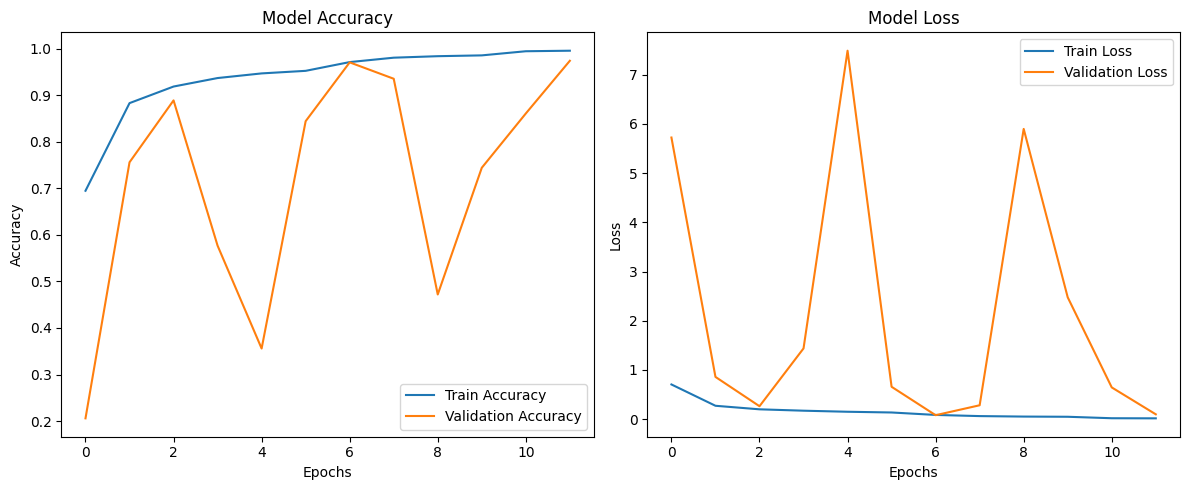

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Normalize input spectrogram data
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

# One-hot encoding labels
y_train_encoded = to_categorical(y_train, num_classes=7)
y_val_encoded = to_categorical(y_val, num_classes=7)
y_test_encoded = to_categorical(y_test, num_classes=7)

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

import time
start_time = time.time()
history = model.fit(
    X_train, y_train_encoded,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val_encoded),
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)
end_time = time.time()
print(f"Training time: {(end_time - start_time) / 60:.2f} minutes")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


119/119 - 1s - 5ms/step - accuracy: 0.9627 - loss: 0.1031
Test Loss: 0.1031
Test Accuracy: 0.9627
Final Accuracy of the model: 96.27%
119/119 - 0s - 4ms/step
Sample Predictions:
True Labels: [1 6 0 2 0 5 1 6 1 4]
Predicted Labels: [1 6 0 2 0 5 1 0 1 4]


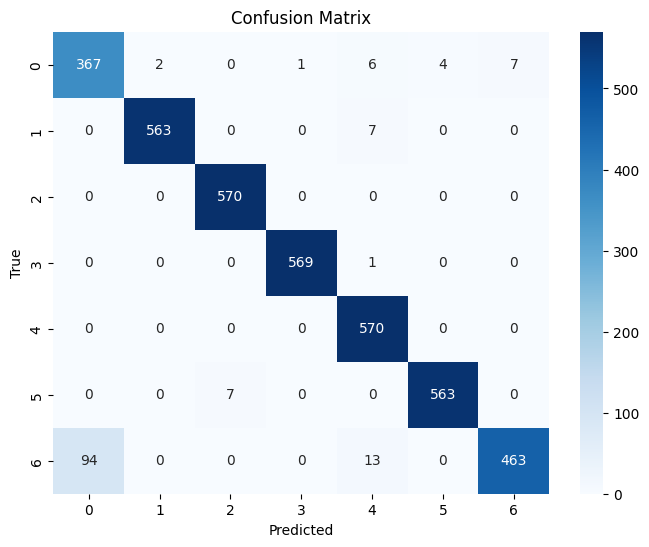

In [10]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_test_encoded = to_categorical(y_test, num_classes=7)

test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=2)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Final Accuracy of the model: {test_accuracy * 100:.2f}%")

predictions = model.predict(X_test, verbose=2)
predicted_classes = predictions.argmax(axis=1)

# Comparing predictions with true labels
true_classes = y_test
print("Sample Predictions:")
print(f"True Labels: {true_classes[:10]}")
print(f"Predicted Labels: {predicted_classes[:10]}")

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()




In [11]:
# Saving the model in H5 format
model.save('/content/drive/MyDrive/Audio_Forensics_Models/asvpoof_2019_model_Transformer.h5')
print("Model saved to '/content/drive/MyDrive/asvpoof_model.h5'")

Model saved to '/content/drive/MyDrive/asvpoof_model.h5'


Model loaded successfully.


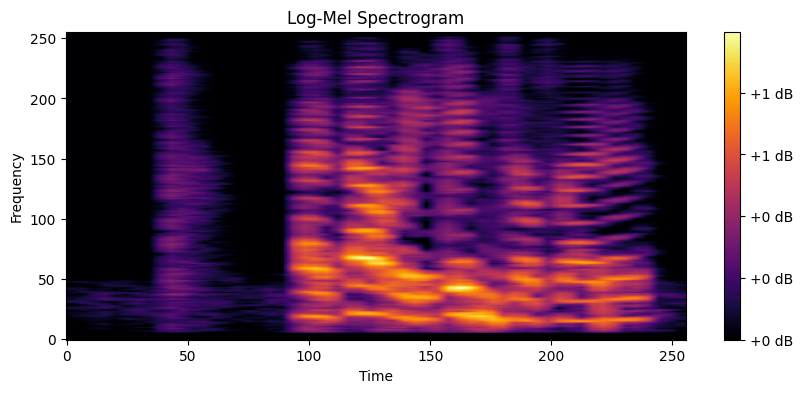

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Audio File: /content/drive/MyDrive/LA_Dataset_Final/Spoof/A05/LA_T_9998119.flac
Predicted Class: 2
Class Probabilities: [[ 0  0 99  0  0  0  0]]
Audio is fake and forgery is Speech Synthesis


In [39]:
import tensorflow as tf
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Loading the saved model
model_path = '/content/drive/MyDrive/Audio_Forensics_Models/asvpoof_2019_model_Transformer.h5'
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully.")

def preprocess_audio(file_path, sr=11000, n_mels=256, hop_length=512):
    audio, _ = librosa.load(file_path, sr=sr)

    spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length
    )

    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    log_spectrogram = (log_spectrogram - log_spectrogram.min()) / (log_spectrogram.max() - log_spectrogram.min())

    # Add channel dimension before resizing
    log_spectrogram = np.expand_dims(log_spectrogram, axis=-1)  # (n_mels, time_steps, 1)

    log_spectrogram = tf.image.resize(log_spectrogram, (256, 256))  # Resize to (256, 256)

    # Converting the tensor to a numpy array before squeezing
    log_spectrogram_np = log_spectrogram.numpy()

    plt.figure(figsize=(10, 4))
    plt.imshow(log_spectrogram_np.squeeze(), cmap='inferno', aspect='auto', origin='lower')
    plt.title('Log-Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    return log_spectrogram

def classify_audio(file_path):
    spectrogram = preprocess_audio(file_path)

    spectrogram = np.expand_dims(spectrogram, axis=0)

    predictions = model.predict(spectrogram)
    predicted_class = np.argmax(predictions, axis=-1)[0]

    probabilities = (predictions * 100).astype(int)

    return predicted_class, probabilities

def get_class_message(predicted_class):
    class_messages = {
        0: "Audio is real",
        1: "Audio is fake and forgery is Speech Synthesis",
        2: "Audio is fake and forgery is Speech Synthesis",
        3: "Audio is fake and forgery is Voice Conversion",
        4: "Audio is fake and forgery is Voice Conversion",
        5: "Audio is fake and forgery is Replay Attack",
        6: "Audio is fake and forgery is Replay Attack with Distant Microphone",
    }
    return class_messages.get(predicted_class, "Unknown class")

audio_file = '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A05/LA_T_9998119.flac'
predicted_class, probabilities = classify_audio(audio_file)

print(f"Audio File: {audio_file}")
print(f"Predicted Class: {predicted_class}")
print(f"Class Probabilities: {probabilities}")

message = get_class_message(predicted_class)
print(message)

Model loaded successfully.


Saving Record (online-voice-recorder.com) (1).mp3 to Record (online-voice-recorder.com) (1) (2).mp3


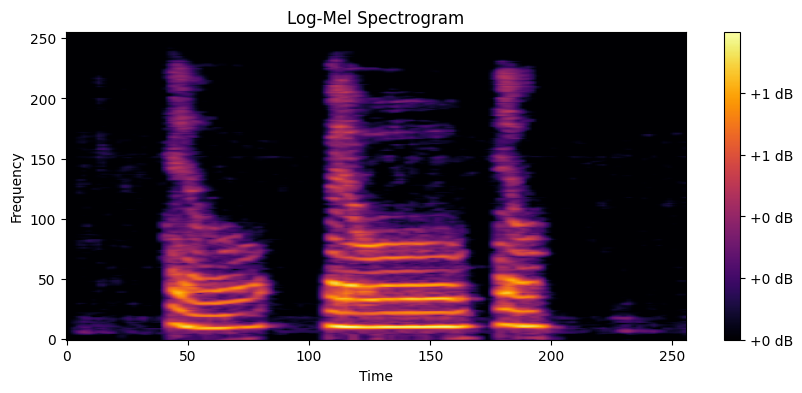

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Audio File: Record (online-voice-recorder.com) (1) (2).mp3
Predicted Class: 2
Class Probabilities: [[ 0  0 99  0  0  0  0]]
Audio is fake and forgery is Speech Synthesis


In [40]:
import tensorflow as tf
import numpy as np
import librosa
from google.colab import files
import matplotlib.pyplot as plt

model_path = '/content/drive/MyDrive/Audio_Forensics_Models/asvpoof_2019_model_Transformer.h5'
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully.")

def preprocess_audio(file_path, sr=11000, n_mels=256, hop_length=512):
    audio, _ = librosa.load(file_path, sr=sr)

    spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length
    )

    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    log_spectrogram = (log_spectrogram - log_spectrogram.min()) / (log_spectrogram.max() - log_spectrogram.min())

    log_spectrogram = np.expand_dims(log_spectrogram, axis=-1)

    log_spectrogram = tf.image.resize(log_spectrogram, (256, 256))

    log_spectrogram_np = log_spectrogram.numpy()

    plt.figure(figsize=(10, 4))
    plt.imshow(log_spectrogram_np.squeeze(), cmap='inferno', aspect='auto', origin='lower')
    plt.title('Log-Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    return log_spectrogram

def classify_audio(file_path):

    spectrogram = preprocess_audio(file_path)

    spectrogram = np.expand_dims(spectrogram, axis=0)

    predictions = model.predict(spectrogram)
    predicted_class = np.argmax(predictions, axis=-1)[0]

    probabilities = (predictions * 100).astype(int)

    return predicted_class, probabilities

def get_class_message(predicted_class):
    class_messages = {
        0: "Audio is real",
        1: "Audio is fake and forgery is Speech Synthesis",
        2: "Audio is fake and forgery is Speech Synthesis",
        3: "Audio is fake and forgery is Voice Conversion",
        4: "Audio is fake and forgery is Voice Conversion",
        5: "Audio is fake and forgery is Replay Attack",
        6: "Audio is fake and forgery is Replay Attack with Distant Microphone",
    }
    return class_messages.get(predicted_class, "Unknown class")

uploaded = files.upload()

audio_file = next(iter(uploaded))

predicted_class, probabilities = classify_audio(audio_file)

print(f"Audio File: {audio_file}")
print(f"Predicted Class: {predicted_class}")
print(f"Class Probabilities: {probabilities}")

message = get_class_message(predicted_class)
print(message)


Using Explainable AI to visualize results

Model loaded successfully.


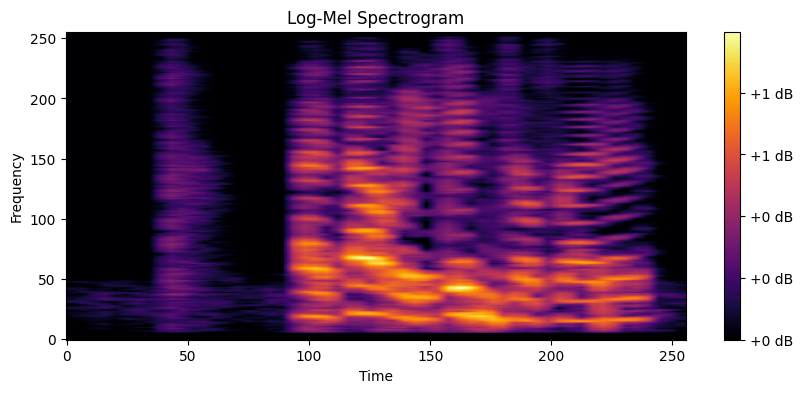

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Activations shape: (1, 4, 64)


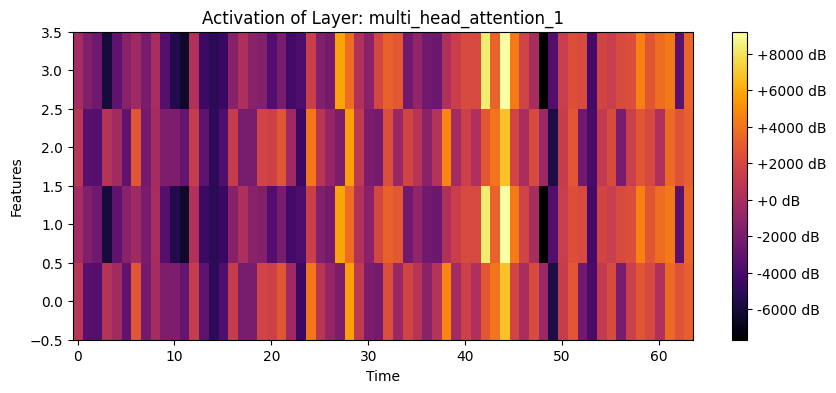

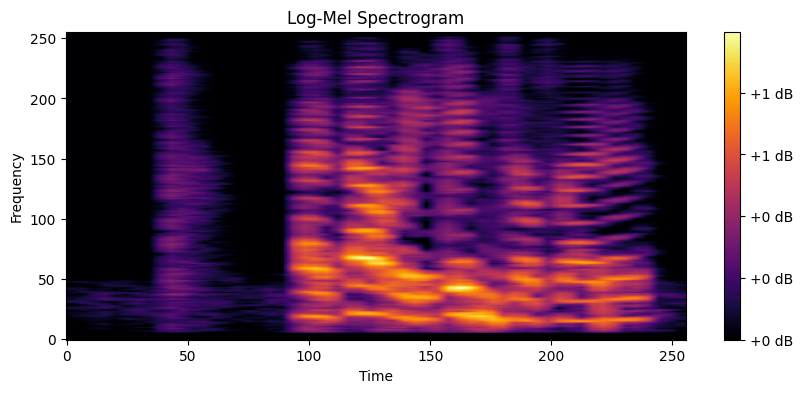

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Audio File: /content/drive/MyDrive/LA_Dataset_Final/Spoof/A05/LA_T_9998119.flac
Predicted Class: 2
Class Probabilities: [[ 0  0 99  0  0  0  0]]
Audio is fake and forgery is Speech Synthesis


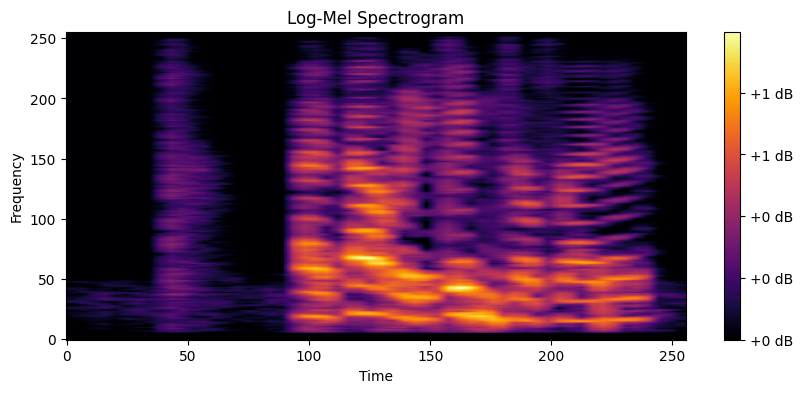

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Activations shape: (1, 4, 64)


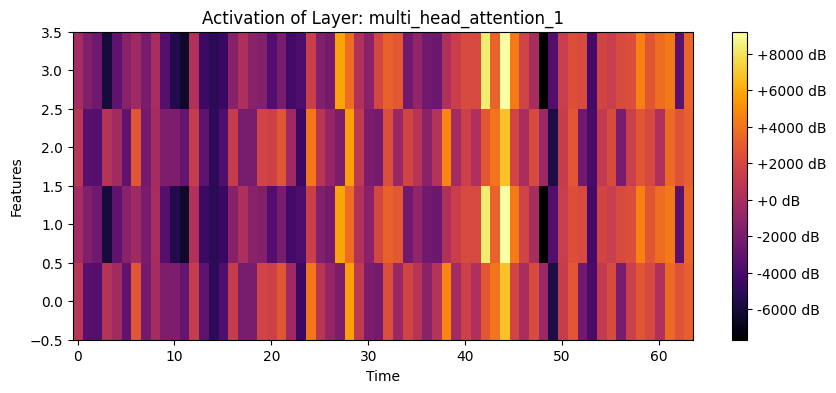

In [43]:
import tensorflow as tf
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

model_path = '/content/drive/MyDrive/Audio_Forensics_Models/asvpoof_2019_model_Transformer.h5'
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully.")

def preprocess_audio(file_path, sr=11000, n_mels=256, hop_length=512):
    audio, _ = librosa.load(file_path, sr=sr)

    spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length
    )

    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    log_spectrogram = (log_spectrogram - log_spectrogram.min()) / (log_spectrogram.max() - log_spectrogram.min())

    log_spectrogram = np.expand_dims(log_spectrogram, axis=-1)

    log_spectrogram = tf.image.resize(log_spectrogram, (256, 256))

    log_spectrogram_np = log_spectrogram.numpy()

    plt.figure(figsize=(10, 4))
    plt.imshow(log_spectrogram_np.squeeze(), cmap='inferno', aspect='auto', origin='lower')
    plt.title('Log-Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    return log_spectrogram

def classify_audio(file_path):
    spectrogram = preprocess_audio(file_path)

    spectrogram = np.expand_dims(spectrogram, axis=0)

    predictions = model.predict(spectrogram)
    predicted_class = np.argmax(predictions, axis=-1)[0]

    probabilities = (predictions * 100).astype(int)

    return predicted_class, probabilities

def get_class_message(predicted_class):
    class_messages = {
        0: "Audio is real",
        1: "Audio is fake and forgery is Speech Synthesis",
        2: "Audio is fake and forgery is Speech Synthesis",
        3: "Audio is fake and forgery is Voice Conversion",
        4: "Audio is fake and forgery is Voice Conversion",
        5: "Audio is fake and forgery is Replay Attack",
        6: "Audio is fake and forgery is Replay Attack with Distant Microphone",
    }
    return class_messages.get(predicted_class, "Unknown class")

def visualize_layer_activation(file_path, layer_name="multi_head_attention_1"):
    spectrogram = preprocess_audio(file_path)

    spectrogram = np.expand_dims(spectrogram, axis=0)

    layer_output = model.get_layer(layer_name).output
    activation_model = Model(inputs=model.input, outputs=layer_output)

    activations = activation_model.predict(spectrogram)

    print(f"Activations shape: {activations.shape}")

    # Visualizing the activations (e.g., for a specific time frame or frequency)
    # Since the activations are 3D, we can plot them as a heatmap
    plt.figure(figsize=(10, 4))
    plt.imshow(activations[0, :, :], cmap='inferno', aspect='auto', origin='lower')
    plt.title(f'Activation of Layer: {layer_name}')
    plt.xlabel('Time')
    plt.ylabel('Features')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

visualize_layer_activation(audio_file, layer_name="multi_head_attention_1")


audio_file = '/content/drive/MyDrive/LA_Dataset_Final/Spoof/A05/LA_T_9998119.flac'
predicted_class, probabilities = classify_audio(audio_file)

print(f"Audio File: {audio_file}")
print(f"Predicted Class: {predicted_class}")
print(f"Class Probabilities: {probabilities}")

message = get_class_message(predicted_class)
print(message)

visualize_layer_activation(audio_file, layer_name="multi_head_attention_1")
